This is to demonstrate how to use the `s1-enumerator` to get a full time series of GUNWs.

We are going basically take each month in acceptable date range and increment by a month and make sure the temporal window is large enough to ensure connectivity across data gaps.

# Parameters

This is what the operator is going to have to change. Will provide some comments.

In [1]:
# toggle user-controlled parameters here
import datetime

# product cutline
aoi_shapefile = 'aois/LaPalma_pathNumber60.geojson'
### Spatial coverage constraint parameter 'azimuth_mismatch'
# The merged SLC area over the AOI is allowed to be smaller by 'azimuth_mismatch' x swath width (i.e. 250km)
azimuth_mismatch = 40

# Define job-name
job_name = aoi_shapefile.split('/')[-1].split('.')[0].split('pathNumber')
job_name = ''.join(job_name)
job_name = job_name[-20:]
# product directory
prod_dir = job_name

# Specify deployment URL
#deploy_url = 'https://hyp3-tibet.asf.alaska.edu' #for Tibet
deploy_url = 'https://hyp3-isce.asf.alaska.edu' #for access

# Number of nearest neighbors
num_neighbors = 2

#set temporal parameters
today = datetime.datetime.now()
# Earliest year for reference frames
START_YEAR = 2014
# Latest year for reference frames
END_YEAR = today.year
# Adjust depending on seasonality
# For annual IFGs, select a single months of interest and you will get what you want.
MONTHS_OF_INTEREST = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [2]:
from s1_enumerator import get_aoi_dataframe,  distill_all_pairs, enumerate_ifgs, get_s1_coverage_tiles, enumerate_ifgs_from_stack, get_s1_stack_by_dataframe
import concurrent
from rasterio.crs import CRS
from s1_enumerator import duplicate_gunw_found
from tqdm import tqdm
from shapely.geometry import Point, shape
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from dateutil.relativedelta import relativedelta
import networkx as nx
import boto3
import hyp3_sdk
import copy

In [3]:
def shapefile_area(file_bbox,
        bounds = False):
    """Compute km\u00b2 area of shapefile."""
    # import dependencies
    from pyproj import Proj

    # loop through polygons
    shape_area = 0
    # pass single polygon as list
    if file_bbox.type == 'Polygon': file_bbox = [file_bbox]
    for polyobj in file_bbox:
        #first check if empty
        if polyobj.is_empty:
            shape_area += 0
            continue
        # get coords
        if bounds:
            # Pass coordinates of bounds as opposed to cutline
            # Necessary for estimating DEM/mask footprints
            WSEN = polyobj.bounds
            lon = np.array([WSEN[0],WSEN[0],WSEN[2],WSEN[2],WSEN[0]])
            lat = np.array([WSEN[1],WSEN[3],WSEN[3],WSEN[1],WSEN[1]])
        else:
            lon, lat = polyobj.exterior.coords.xy

        # use equal area projection centered on/bracketing AOI
        pa = Proj("+proj=aea +lat_1={} +lat_2={} +lat_0={} +lon_0={}". \
             format(min(lat), max(lat), (max(lat)+min(lat))/2, \
             (max(lon)+min(lon))/2))
        x, y = pa(lon, lat)
        cop = {"type": "Polygon", "coordinates": [zip(x, y)]}
        shape_area += shape(cop).area/1e6  # area in km^2

    return shape_area

In [4]:
def continuous_time(product_df, iter_id='fileID'):
    """
    Split the products into spatiotemporally continuous groups.
    Split products by individual, continuous interferograms.
    Input must be already sorted by pair and start-time to fit
    the logic scheme below.
    Using their time-tags, this function determines whether or not
    successive products are in the same orbit.
    If in the same orbit, the program determines whether or not they
    overlap in time and are therefore spatially contiguous,
    and rejects/reports cases for which there is no temporal overlap
    and therefore a spatial gap.
    """
    from shapely.ops import unary_union

    # pass scenes that have no gaps
    sorted_products = []
    track_rejected_inds = []
    pair_dict = {}
    product_df_dict = product_df.to_dict('records')
    # Check for (and remove) duplicate products
    # If multiple pairs in list, cycle through
    # and evaluate temporal connectivity.
    for i in enumerate(product_df_dict[:-1]):
        # Parse the first frame's metadata
        scene_start = i[1]['startTime']
        scene_end = i[1]['stopTime']
        first_frame_ind = i[1]['ind_col']
        first_frame = datetime.datetime.strptime( \
                i[1]['fileID'][17:25], "%Y%m%d")
        # Parse the second frame's metadata
        new_scene_start = product_df_dict[i[0]+1]['startTime']
        new_scene_end = product_df_dict[i[0]+1]['stopTime']
        next_frame_ind = product_df_dict[i[0]+1]['ind_col']
        next_frame = datetime.datetime.strptime( \
                product_df_dict[i[0]+1]['fileID'][17:25], "%Y%m%d")

        # Determine if next product in time is in same orbit AND overlaps
        # AND corresponds to same scene
        # If it is within same orbit cycle, try to append scene.
        # This accounts for day change.
        if abs(new_scene_end-scene_end) <= \
                datetime.timedelta(minutes=100) \
                and abs(next_frame-first_frame) <= \
                datetime.timedelta(days=1):
            # Don't export product if it is already tracked
            # as a rejected scene
            if first_frame_ind in track_rejected_inds or \
                    next_frame_ind in track_rejected_inds:
                track_rejected_inds.append(first_frame_ind)
                track_rejected_inds.append(next_frame_ind)

            # Only pass scene if it temporally overlaps with reference scene
            elif ((scene_end <= new_scene_start) and \
                    (new_scene_end <= scene_start)) or \
                    ((scene_end >= new_scene_start) and \
                    (new_scene_end >= scene_start)):
                # Check if dictionary for scene already exists,
                # and if it does then append values
                try:
                    dict_ind = sorted_products.index(next(item for item \
                            in sorted_products if i[1][iter_id] \
                            in item[iter_id]))
                    sorted_products[dict_ind] = {key: np.hstack([value] + \
                         [product_df_dict[i[0]+1][key]]).tolist() \
                         for key, value in sorted_products[dict_ind].items()}
                # Match corresponding to scene NOT found,
                # so initialize dictionary for new scene
                except:
                    sorted_products.extend([dict(zip(i[1].keys(), \
                            [list(a) for a in zip(i[1].values(), \
                            product_df_dict[i[0]+1].values())]))])

            # Else if scene doesn't overlap, this means there is a gap.
            # Reject date from product list,
            # and keep track of all failed dates
            else:
                track_rejected_inds.append(first_frame_ind)
                track_rejected_inds.append(next_frame_ind)
        # Products correspond to different dates,
        # So pass both as separate scenes.
        else:
            # Check if dictionary for corresponding scene already exists.
            if [item for item in sorted_products if i[1][iter_id] in \
                    item[iter_id]]==[] and i[1]['ind_col'] not in \
                    track_rejected_inds:
                sorted_products.extend([dict(zip(i[1].keys(), \
                        [list(a) for a in zip(i[1].values())]))])
            # Initiate new scene
            if [item for item in sorted_products if \
                    product_df_dict[i[0]+1][iter_id] in item[iter_id]]==[] \
                    and next_frame_ind not in track_rejected_inds:
                sorted_products.extend([dict(zip( \
                        product_df_dict[i[0]+1].keys(), \
                        [list(a) for a in \
                        zip(product_df_dict[i[0]+1].values())]))])
            if first_frame_ind in track_rejected_inds:
                track_rejected_inds.append(first_frame_ind)
            if next_frame_ind in track_rejected_inds:
                track_rejected_inds.append(next_frame_ind)

    # Remove duplicate dates
    track_rejected_inds = list(set(track_rejected_inds))
    if len(track_rejected_inds) > 0:
        print("{}/{} scenes rejected as stitched IFGs have gaps".format( \
             len(track_rejected_inds), len(product_df)))
        # Provide report of which files were kept vs. which were not.
        print("Specifically, the following scenes were rejected:")
        for item in product_df_dict:
            if item['ind_col'] in track_rejected_inds:
                print(item['fileID'])
    else:
        print("All {} scenes are spatially continuous.".format( \
             len(sorted_products)))

    # pass scenes that have no gaps
    sorted_products = [item for item in sorted_products \
            if not (any(x in track_rejected_inds for x in item['ind_col']))]

    # Report dictionaries for all valid products
    if sorted_products == []: #Check if pairs were successfully selected
        raise Exception('No scenes meet spatial criteria'
                        'due to gaps and/or invalid input.'
                        'Nothing to export.')

    # Combine polygons
    for i in enumerate(sorted_products):
        sorted_products[i[0]]['geometry'] = unary_union(i[1]['geometry'])

    # combine and record scenes with gaps
    track_kept_inds = pd.DataFrame(sorted_products)['ind_col'].to_list()
    track_kept_inds = [item for sublist in track_kept_inds for item in sublist]
    temp_gap_scenes_dict = [item for item in product_df_dict \
            if not item['ind_col'] in track_kept_inds]
    gap_scenes_dict = []
    for i in enumerate(temp_gap_scenes_dict[:-1]):
        # Parse the first frame's metadata
        first_frame_ind = i[1]['ind_col']
        first_frame = datetime.datetime.strptime( \
                i[1]['fileID'][17:25], "%Y%m%d")
        # Parse the second frame's metadata
        next_frame_ind = temp_gap_scenes_dict[i[0]+1]['ind_col']
        next_frame = datetime.datetime.strptime( \
                temp_gap_scenes_dict[i[0]+1]['fileID'][17:25], "%Y%m%d")
        # Determine if next product in time is in same orbit
        # If it is within same orbit cycle, try to append scene.
        # This accounts for day change.
        if abs(next_frame-first_frame) <= \
            datetime.timedelta(days=1):
            # Check if dictionary for scene already exists,
            # and if it does then append values
            try:
                dict_ind = gap_scenes_dict.index(next(item for item \
                        in gap_scenes_dict if i[1][iter_id] \
                        in item[iter_id]))
                gap_scenes_dict[dict_ind] = {key: np.hstack([value] + \
                        [temp_gap_scenes_dict[i[0]+1][key]]).tolist() \
                        for key, value in gap_scenes_dict[dict_ind].items()}
            # Match corresponding to scene NOT found,
            # so initialize dictionary for new scene
            except:
                gap_scenes_dict.extend([dict(zip(i[1].keys(), \
                        [list(a) for a in zip(i[1].values(), \
                        temp_gap_scenes_dict[i[0]+1].values())]))])
        # Products correspond to different dates,
        # So pass both as separate scenes.
        else:
            # Check if dictionary for corresponding scene already exists.
            if [item for item in gap_scenes_dict if i[1][iter_id] in \
                    item[iter_id]]==[]:
                gap_scenes_dict.extend([dict(zip(i[1].keys(), \
                        [list(a) for a in zip(i[1].values())]))])
            # Initiate new scene
            if [item for item in gap_scenes_dict if \
                    temp_gap_scenes_dict[i[0]+1][iter_id] in item[iter_id]]==[]:
                gap_scenes_dict.extend([dict(zip( \
                        temp_gap_scenes_dict[i[0]+1].keys(), \
                        [list(a) for a in \
                        zip(temp_gap_scenes_dict[i[0]+1].values())]))])

    # there may be some extra missed pairs with gaps
    if gap_scenes_dict != []:
        extra_track_rejected_inds = pd.DataFrame(gap_scenes_dict)['ind_col'].to_list()
        extra_track_rejected_inds = [item for sublist in extra_track_rejected_inds for item in sublist]
        track_rejected_inds.extend(extra_track_rejected_inds)

    return sorted_products, track_rejected_inds, gap_scenes_dict

In [5]:
def minimum_overlap_query(tiles,
        aoi,
        azimuth_mismatch=0.01,
        iter_id='fileID'):
    """
    Master function managing checks for SAR scene spatiotemporal contiguity
    and filtering out scenes based off of user-defined spatial coverage threshold
    """
    # initiate dataframe
    tiles = tiles.sort_values(['startTime'])
    updated_tiles = tiles.copy()

    # Drop scenes that don't intersect with AOI at all
    orig_len = updated_tiles.shape[0]
    for index, row in tiles.iterrows():
        intersection_area = aoi.intersection(row['geometry'])
        overlap_area = shapefile_area(intersection_area)
        aoi_area = shapefile_area(aoi)
        percentage_coverage = (overlap_area/aoi_area)*100
        if percentage_coverage == 0:
            drop_ind = updated_tiles[updated_tiles['fileID'] == row['fileID']].index
            updated_tiles = updated_tiles.drop(index=drop_ind)
    updated_tiles = updated_tiles.reset_index(drop=True)
    print("{}/{} scenes rejected for not intersecting with the AOI".format( \
          orig_len-updated_tiles.shape[0], orig_len))

    # group IFGs spatiotemporally
    updated_tiles['ind_col'] = range(0, len(updated_tiles))
    updated_tiles_dict, dropped_indices, gap_scenes_dict = continuous_time(updated_tiles, iter_id)
    for i in dropped_indices:
        drop_ind = updated_tiles.index[updated_tiles['ind_col'] == i]
        updated_tiles.drop(drop_ind, inplace=True)
    updated_tiles = updated_tiles.reset_index(drop=True)
    
    # Kick out scenes that do not meet user-defined spatial threshold
    aoi_area = shapefile_area(aoi)
    orig_len = updated_tiles.shape[0]
    track_rejected_inds = []
    minimum_overlap_threshold = aoi_area - (250 * azimuth_mismatch)
    print("")
    print("AOI coverage: {}".format(aoi_area))
    print("Allowable area of miscoverage: {}".format(250 * azimuth_mismatch))
    print("minimum_overlap_threshold: {}".format(minimum_overlap_threshold))
    print("")
    if minimum_overlap_threshold < 0:
        raise Exception('WARNING: user-defined mismatch of {}km\u00b2 too large relative to specified AOI'.format(azimuth_mismatch))
    for i in enumerate(updated_tiles_dict):
        intersection_area = aoi.intersection(i[1]['geometry'])
        overlap_area = shapefile_area(intersection_area)
        # Kick out scenes below specified overlap threshold
        if minimum_overlap_threshold > overlap_area:
            for iter_ind in enumerate(i[1]['ind_col']):
                track_rejected_inds.append(iter_ind[1])
                print("Rejected scene {} has only {}km\u00b2 overlap with AOI".format( \
                    i[1]['fileID'][iter_ind[0]], int(overlap_area)))
                drop_ind = updated_tiles[updated_tiles['ind_col'] == iter_ind[1]].index
                updated_tiles = updated_tiles.drop(index=drop_ind)
    updated_tiles = updated_tiles.reset_index(drop=True)
    print("{}/{} scenes rejected for not meeting defined spatial criteria".format( \
          orig_len-updated_tiles.shape[0], orig_len))

    # record rejected scenes separately
    rejected_scenes_dict = [item for item in updated_tiles_dict \
            if (any(x in track_rejected_inds for x in item['ind_col']))]
    # pass scenes that are not tracked as rejected
    updated_tiles_dict = [item for item in updated_tiles_dict \
            if not (any(x in track_rejected_inds for x in item['ind_col']))]

    return updated_tiles, pd.DataFrame(updated_tiles_dict), pd.DataFrame(gap_scenes_dict), pd.DataFrame(rejected_scenes_dict)

In [6]:
def pair_spatial_check(tiles,
        aoi,
        azimuth_mismatch=0.01,
        iter_id='fileID'):
    """
    Santity check function to confirm selected pairs meet user-defined spatial coverage threshold
    """
    tiles['ind_col'] = range(0, len(tiles))
    tiles = tiles.drop(columns=['reference', 'secondary'])
    tiles_dict, dropped_pairs, gap_scenes_dict = continuous_time(tiles, iter_id='ind_col')

    # Kick out scenes that do not meet user-defined spatial threshold
    aoi_area = shapefile_area(aoi)
    orig_len = tiles.shape[0]
    minimum_overlap_threshold = aoi_area - (250 * azimuth_mismatch)
    if minimum_overlap_threshold < 0:
        raise Exception('WARNING: user-defined mismatch of {}km\u00b2 too large relative to specified AOI'.format(azimuth_mismatch))
    for i in enumerate(tiles_dict):
        intersection_area = aoi.intersection(i[1]['geometry'])
        overlap_area = shapefile_area(intersection_area)
        # Kick out scenes below specified overlap threshold
        if minimum_overlap_threshold > overlap_area:
            for iter_ind in enumerate(i[1]['ind_col']):
                print("Rejected pair {} has only {}km\u00b2 overlap with AOI {}ID {}Ind".format( \
                      i[1]['reference_date'][iter_ind[0]].replace('-', '') + '_' + \
                      i[1]['secondary_date'][iter_ind[0]].replace('-', ''), \
                      overlap_area, iter_ind[1], i[0]))
                drop_ind = tiles[tiles['ind_col'] == iter_ind[1]].index
                tiles = tiles.drop(index=drop_ind)
    tiles = tiles.reset_index(drop=True)
    print("{}/{} scenes rejected for not meeting defined spatial criteria".format( \
          orig_len-tiles.shape[0], orig_len))

    return pd.DataFrame(tiles_dict)

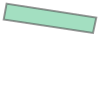

In [7]:
df_aoi = gpd.read_file(aoi_shapefile)
aoi = df_aoi.geometry.unary_union
aoi

Currently, there is a lot of data in each of the rows above. We really only need the AOI `geometry` and the `path_number`.

In [9]:
path_numbers = df_aoi.path_number.unique().tolist()

[169]

# Generate a stack

Using all the tiles that are needed to cover the AOI we make a geometric query based on the frame. We now include only the path we are interested in.

In [10]:
path_dict = {}
path_dict['pathNumber'] = str(path_numbers[0])
aoi_geometry = pd.DataFrame([path_dict])
aoi_geometry = gpd.GeoDataFrame(aoi_geometry, geometry=[shape(aoi)], crs=CRS.from_epsg(4326))
aoi_geometry['pathNumber'] = aoi_geometry['pathNumber'].astype(int)

In [11]:
df_stack = get_s1_stack_by_dataframe(aoi_geometry,
                                     path_numbers=path_numbers)

In [12]:
f'We have {df_stack.shape[0]} frames in our stack'

'We have 293 frames in our stack'

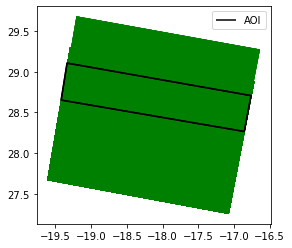

In [13]:
fig, ax = plt.subplots()

df_stack.plot(ax=ax, alpha=.5, color='green', label='Frames interesecting tile')
df_aoi.exterior.plot(color='black', ax=ax, label='AOI')
plt.legend()

Note, we now see the frames cover the entire AOI as we expect.

First remove all scenes that do not produce spatiotemporally contiguous pairs and not meet specified intersection threshold

In [14]:
df_stack, df_stack_dict, gap_scenes_dict, rejected_scenes_dict = minimum_overlap_query(df_stack, aoi, azimuth_mismatch=azimuth_mismatch)

0/293 scenes rejected for not intersecting with the AOI
All 293 scenes are spatially continuous.

AOI coverage: 12816.439137574667
Allowable area of miscoverage: 1250
minimum_overlap_threshold: 11566.439137574667

0/293 scenes rejected for not meeting defined spatial criteria


In [15]:
f'We have {df_stack.shape[0]} frames in our stack'

'We have 293 frames in our stack'

Plot acquisitions that aren't continuous (i.e. have gaps)

In [16]:
if not gap_scenes_dict.empty:
    gap_scenes_dict =  gap_scenes_dict.sort_values(by=['start_date'])
    for index, row in gap_scenes_dict.iterrows():
        fig, ax = plt.subplots()
        p = gpd.GeoSeries(row['geometry'])
        p.exterior.plot(color='black', ax=ax, label=row['start_date_str'][0])
        df_aoi.exterior.plot(color='red', ax=ax, label='AOI')
        plt.legend()
        plt.show

Plot all mosaicked acquisitions that were rejected for not meeting user-specified spatial constraints

In [17]:
if not rejected_scenes_dict.empty:
    rejected_scenes_dict =  rejected_scenes_dict.sort_values(by=['start_date'])
    fig, ax = plt.subplots()
    for index, row in rejected_scenes_dict.iterrows():
        p = gpd.GeoSeries(row['geometry'])
        p.exterior.plot(color='black', ax=ax)
    df_aoi.exterior.plot(color='red', ax=ax, label='AOI')
    plt.legend()

Plot each individual mosaicked acquisitions that were rejected for not meeting user-specified spatial constraints

In [18]:
if not rejected_scenes_dict.empty:
    for index, row in rejected_scenes_dict.iterrows():
        fig, ax = plt.subplots()
        p = gpd.GeoSeries(row['geometry'])
        p.exterior.plot(color='black', ax=ax, label=row['start_date_str'][0])
        df_aoi.exterior.plot(color='red', ax=ax, label='AOI')
        plt.legend()
        plt.show

Plot all mosaicked acquisitions that meet user-defined spatial coverage

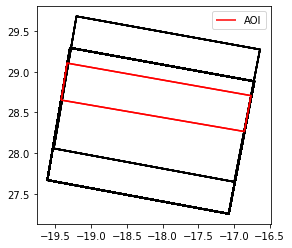

In [19]:
fig, ax = plt.subplots()

for index, row in df_stack_dict.iterrows():
    p = gpd.GeoSeries(row['geometry'])
    p.exterior.plot(color='black', ax=ax)
df_aoi.exterior.plot(color='red', ax=ax, label='AOI')
plt.legend()

Next, we filter the stack by month to ensure we only have SLCs we need.

In [20]:
df_stack_month = df_stack[df_stack.start_date.dt.month.isin(MONTHS_OF_INTEREST)]

We will create a list of ```min_reference_dates``` by taking the most recent date from the SLC stack ```df_stack_month``` as the start date. A range of dates with interval of ```-6 days``` is then generated until ```(START_YEAR, MONTHS_OF_INTEREST[0], 1)```.

In [21]:
latestSLC_date = df_stack_month.iloc[-1].start_date
min_reference_dates = [latestSLC_date - datetime.timedelta(days=i) for i in range(0, (latestSLC_date-datetime.datetime(START_YEAR,MONTHS_OF_INTEREST[0],1)).days, 6)]

We can now enumerate the SLC pairs that will produce the interferograms (GUNWs) based on initially defined parameters that are exposed at the top-level of this jupyter notebook.

In [22]:
ifg_pairs = []

for min_ref_date in tqdm(min_reference_dates):
    temporal_window_days = 365*3
    temp = enumerate_ifgs_from_stack(df_stack_month,
                                     aoi,
                                     min_ref_date,
                                     enumeration_type='tile', # options are 'tile' and 'path'. 'path' processes multiple references simultaneously
                                     min_days_backward=0,
                                     num_neighbors_ref=1,
                                     num_neighbors_sec=num_neighbors,
                                     temporal_window_days=temporal_window_days,
                                     min_tile_aoi_overlap_km2=.1,#Minimum reference tile overlap of AOI in km2
                                     min_ref_tile_overlap_perc=.1,#Relative overlap of secondary frames over reference frame
                                     minimum_ifg_area_km2=0.1,#The minimum overlap of reference and secondary in km2
                                     minimum_path_intersection_km2=.1,#Overlap of common track union with respect to AOI in km2
                                         )

    ifg_pairs += temp

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:47<00:00, 10.56it/s]


In [23]:
f'The number of GUNWs (likely lots of duplicates) is {len(ifg_pairs)}'

'The number of GUNWs (likely lots of duplicates) is 624'

# Get Dataframe

In [24]:
df_pairs = distill_all_pairs(ifg_pairs)

In [25]:
f"# of GUNWs: ' {df_pairs.shape[0]}"

"# of GUNWs: ' 624"

As a sanity check, confirm all IFG pairs meet user-defined spatial coverage

Check if there are any gaps in the mosaicked IFGs, or if any are rejected for not meeting user-specified spatial constraints

*NOTE: No products should be rejected at this stage. If any are, there is a problem either due to a:
1) Loose constraint on `azimuth_mismatch` variable whereby scenes not encompassing the entire AOI are getting passed
2) User-driven error
3) Bug in the code

In [26]:
df_pairs_dict = pair_spatial_check(df_pairs, aoi, azimuth_mismatch=azimuth_mismatch)

All 623 scenes are spatially continuous.
0/624 scenes rejected for not meeting defined spatial criteria


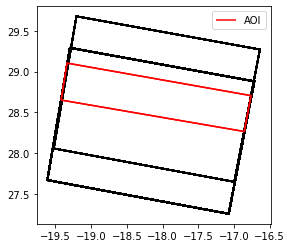

In [27]:
fig, ax = plt.subplots()

for index, row in df_pairs_dict.iterrows():
    p = gpd.GeoSeries(row['geometry'])
    p.exterior.plot(color='black', ax=ax)
df_aoi.exterior.plot(color='red', ax=ax, label='AOI')
plt.legend()

# Deduplication Pt. 1

A `GUNW` is uniquely determined by the reference and secondary IDs. We contanenate these sorted lists and generate a lossy hash to deduplicate products we may have introduced from the enumeration above.

In [28]:
import hashlib
import json


def get_gunw_hash_id(reference_ids: list, secondary_ids: list) -> str:
    all_ids = json.dumps([' '.join(sorted(reference_ids)),
                          ' '.join(sorted(secondary_ids))
                          ]).encode('utf8')
    hash_id = hashlib.md5(all_ids).hexdigest()
    return hash_id

In [29]:
def hasher(row):
    return get_gunw_hash_id(row['reference'], row['secondary'])

df_pairs['hash_id'] = df_pairs.apply(hasher, axis=1)
df_pairs.head(5)

,reference,secondary,reference_date,secondary_date,path_number,geometry,startTime,stopTime,fileID,ind_col,hash_id
0,[S1A_IW_SLC__1SDV_20220309T071058_20220309T071...,[S1A_IW_SLC__1SDV_20220225T071058_20220225T071...,2022-03-09,2022-02-25,169,"POLYGON ((-19.29457 29.29288, -19.29457 29.292...",2022-02-25 07:10:58,2022-02-25 07:11:25,S1A_IW_SLC__1SDV_20220309T071058_20220309T0711...,0,5d19a494d35e0120d047db4bb8896bda
1,[S1A_IW_SLC__1SDV_20220309T071058_20220309T071...,[S1A_IW_SLC__1SDV_20220213T071059_20220213T071...,2022-03-09,2022-02-13,169,"POLYGON ((-19.29463 29.29259, -19.29463 29.292...",2022-02-13 07:10:59,2022-02-13 07:11:25,S1A_IW_SLC__1SDV_20220309T071058_20220309T0711...,1,c720c59d87b3bae901c277ed44f69c70
2,[S1A_IW_SLC__1SDV_20220309T071058_20220309T071...,[S1A_IW_SLC__1SDV_20220225T071058_20220225T071...,2022-03-09,2022-02-25,169,"POLYGON ((-19.29457 29.29288, -19.29457 29.292...",2022-02-25 07:10:58,2022-02-25 07:11:25,S1A_IW_SLC__1SDV_20220309T071058_20220309T0711...,2,5d19a494d35e0120d047db4bb8896bda
3,[S1A_IW_SLC__1SDV_20220309T071058_20220309T071...,[S1A_IW_SLC__1SDV_20220213T071059_20220213T071...,2022-03-09,2022-02-13,169,"POLYGON ((-19.29463 29.29259, -19.29463 29.292...",2022-02-13 07:10:59,2022-02-13 07:11:25,S1A_IW_SLC__1SDV_20220309T071058_20220309T0711...,3,c720c59d87b3bae901c277ed44f69c70
4,[S1A_IW_SLC__1SDV_20220225T071058_20220225T071...,[S1A_IW_SLC__1SDV_20220213T071059_20220213T071...,2022-02-25,2022-02-13,169,"POLYGON ((-19.29500 29.29265, -19.29500 29.292...",2022-02-13 07:10:59,2022-02-13 07:11:25,S1A_IW_SLC__1SDV_20220225T071058_20220225T0711...,4,3f0faf4bd2777c3fea9f61ad3c97729c


In [30]:
f"# of duplicated entries: {df_pairs.duplicated(subset=['hash_id']).sum()}"

'# of duplicated entries: 41'

In [31]:
df_pairs = df_pairs.drop_duplicates(subset=['hash_id']).reset_index(drop=True)
f"# of UNIQUE GUNWs: {df_pairs.shape[0]}"

'# of UNIQUE GUNWs: 583'

# Viewing GUNW pairs

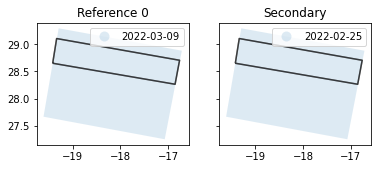

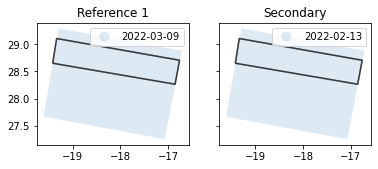

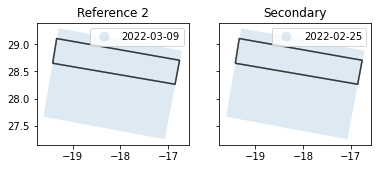

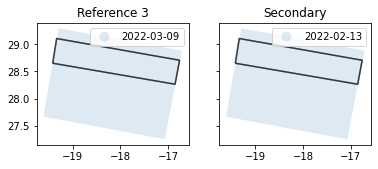

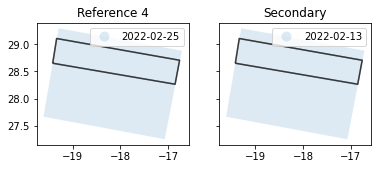

In [32]:
# start index
M = 0
# number of pairs to view
N = 5

for J in range(M, M + N):
    pair = ifg_pairs[J]

    fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)

    df_ref_plot = pair['reference']
    df_sec_plot = pair['secondary']

    df_ref_plot.plot(column='start_date_str', 
                     legend=True, 
                     ax=axs[0], alpha=.15)
    df_aoi.exterior.plot(ax=axs[0], alpha=.5, color='black')
    axs[0].set_title('Reference')

    df_sec_plot.plot(column='start_date_str', 
                     legend=True, 
                     ax=axs[1], alpha=.15)
    df_aoi.exterior.plot(ax=axs[1], alpha=.5, color='black')
    
    axs[0].set_title(f'Reference {J}')
    axs[1].set_title('Secondary')

# Update types for Graphical Analysis

We want to do some basic visualization to support the understanding if we traverse time correctly. We do some simple standard pandas manipulation.

In [33]:
df_pairs['reference_date'] = pd.to_datetime(df_pairs['reference_date'])
df_pairs['secondary_date'] = pd.to_datetime(df_pairs['secondary_date'])
df_pairs.head()

,reference,secondary,reference_date,secondary_date,path_number,geometry,startTime,stopTime,fileID,ind_col,hash_id
0,[S1A_IW_SLC__1SDV_20220309T071058_20220309T071...,[S1A_IW_SLC__1SDV_20220225T071058_20220225T071...,2022-03-09,2022-02-25,169,"POLYGON ((-19.29457 29.29288, -19.29457 29.292...",2022-02-25 07:10:58,2022-02-25 07:11:25,S1A_IW_SLC__1SDV_20220309T071058_20220309T0711...,0,5d19a494d35e0120d047db4bb8896bda
1,[S1A_IW_SLC__1SDV_20220309T071058_20220309T071...,[S1A_IW_SLC__1SDV_20220213T071059_20220213T071...,2022-03-09,2022-02-13,169,"POLYGON ((-19.29463 29.29259, -19.29463 29.292...",2022-02-13 07:10:59,2022-02-13 07:11:25,S1A_IW_SLC__1SDV_20220309T071058_20220309T0711...,1,c720c59d87b3bae901c277ed44f69c70
2,[S1A_IW_SLC__1SDV_20220225T071058_20220225T071...,[S1A_IW_SLC__1SDV_20220213T071059_20220213T071...,2022-02-25,2022-02-13,169,"POLYGON ((-19.29500 29.29265, -19.29500 29.292...",2022-02-13 07:10:59,2022-02-13 07:11:25,S1A_IW_SLC__1SDV_20220225T071058_20220225T0711...,4,3f0faf4bd2777c3fea9f61ad3c97729c
3,[S1A_IW_SLC__1SDV_20220225T071058_20220225T071...,[S1A_IW_SLC__1SDV_20220201T071058_20220201T071...,2022-02-25,2022-02-01,169,"POLYGON ((-16.71538 28.88156, -16.71538 28.881...",2022-02-01 07:10:58,2022-02-01 07:11:25,S1A_IW_SLC__1SDV_20220225T071058_20220225T0711...,5,db91bb59d22a30455d9cbd3864c588c3
4,[S1A_IW_SLC__1SDV_20220213T071059_20220213T071...,[S1A_IW_SLC__1SDV_20220201T071058_20220201T071...,2022-02-13,2022-02-01,169,"POLYGON ((-16.71558 28.88131, -16.71558 28.881...",2022-02-01 07:10:58,2022-02-01 07:11:25,S1A_IW_SLC__1SDV_20220213T071059_20220213T0711...,8,b30e4ebe4c5e573c9e36fffe63459e1b


# Visualize a Date Graph from Time Series

We can put this into a network Directed Graph and use some simple network functions to check connectivity.

We are going to use just dates for nodes, though you could use `(ref_date, hash_id)` for nodes and then inspect connected components. That is for another notebook.

In [34]:
list(zip(df_pairs.reference_date, df_pairs.secondary_date))[:15]

[(Timestamp('2022-03-09 00:00:00'), Timestamp('2022-02-25 00:00:00')),
 (Timestamp('2022-03-09 00:00:00'), Timestamp('2022-02-13 00:00:00')),
 (Timestamp('2022-02-25 00:00:00'), Timestamp('2022-02-13 00:00:00')),
 (Timestamp('2022-02-25 00:00:00'), Timestamp('2022-02-01 00:00:00')),
 (Timestamp('2022-02-13 00:00:00'), Timestamp('2022-02-01 00:00:00')),
 (Timestamp('2022-02-13 00:00:00'), Timestamp('2022-01-20 00:00:00')),
 (Timestamp('2022-02-01 00:00:00'), Timestamp('2022-01-20 00:00:00')),
 (Timestamp('2022-02-01 00:00:00'), Timestamp('2022-01-08 00:00:00')),
 (Timestamp('2022-01-20 00:00:00'), Timestamp('2022-01-08 00:00:00')),
 (Timestamp('2022-01-20 00:00:00'), Timestamp('2021-12-27 00:00:00')),
 (Timestamp('2022-01-08 00:00:00'), Timestamp('2021-12-27 00:00:00')),
 (Timestamp('2022-01-08 00:00:00'), Timestamp('2021-12-21 00:00:00')),
 (Timestamp('2021-12-27 00:00:00'), Timestamp('2021-12-21 00:00:00')),
 (Timestamp('2021-12-27 00:00:00'), Timestamp('2021-12-15 00:00:00')),
 (Time

In [35]:
unique_dates = df_pairs.reference_date.tolist() + df_pairs.secondary_date.tolist()
unique_dates = sorted(list(set(unique_dates)))
unique_dates[:5]

[Timestamp('2017-01-16 00:00:00'),
 Timestamp('2017-01-28 00:00:00'),
 Timestamp('2017-02-09 00:00:00'),
 Timestamp('2017-02-21 00:00:00'),
 Timestamp('2017-03-05 00:00:00')]

In [36]:
date2node = {date: k for (k, date) in enumerate(unique_dates)}
node2date = {k: date for (date, k) in date2node.items()}

In [37]:
%matplotlib widget
G = nx.DiGraph()

edges = [(date2node[ref_date], date2node[sec_date]) 
         for (ref_date, sec_date) in zip(df_pairs.reference_date, df_pairs.secondary_date)]
G.add_edges_from(edges)

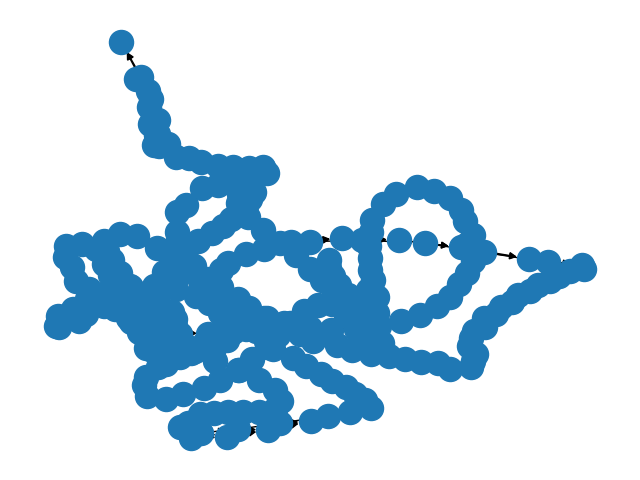

In [38]:
nx.draw(G)

This function checks there is a path from the first date to the last one. The y-axis is created purely for display so doesn't really indicated anything but flow by month.

In [39]:
nx.has_path(G, 
            target=date2node[unique_dates[0]],
            source=date2node[unique_dates[-1]])

True

Ensure that the result above returns a ```True``` value to be able to produce a time-series.

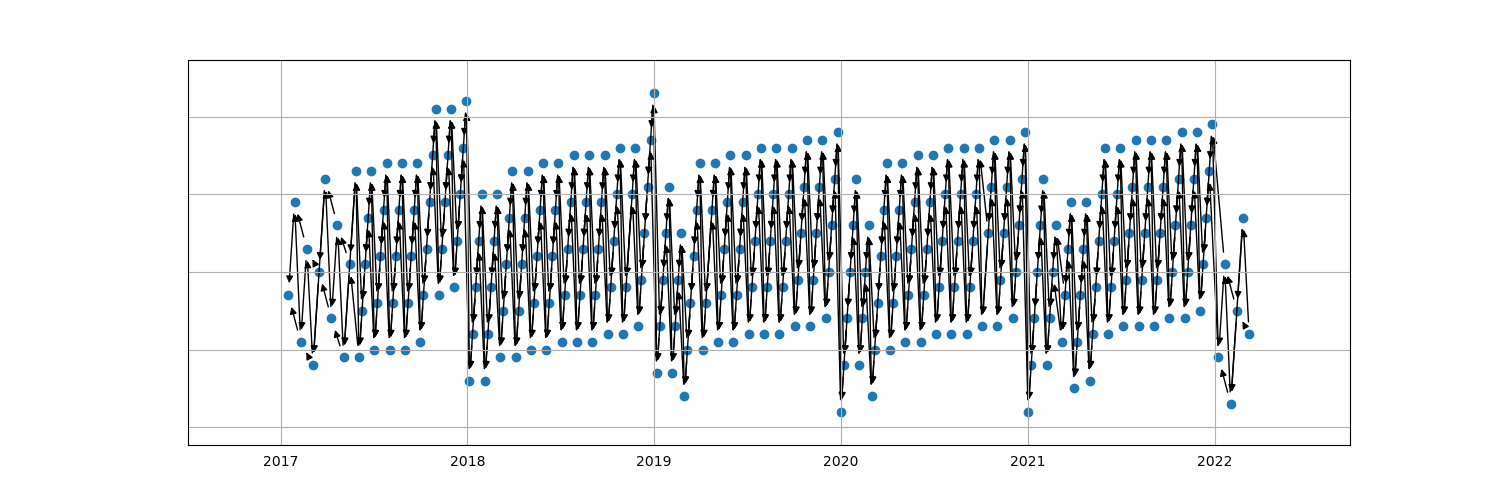

In [40]:
fig, ax = plt.subplots(figsize=(15, 5))

increment = [date.month + date.day for date in unique_dates]

# source: https://stackoverflow.com/a/27852570
scat = ax.scatter(unique_dates, increment)
position = scat.get_offsets().data

pos = {date2node[date]: position[k] for (k, date) in enumerate(unique_dates)}
nx.draw_networkx_edges(G, pos=pos, ax=ax)
ax.grid('on')
ax.tick_params(axis='x',
               which='major',
               labelbottom=True,
               labelleft=True)
ymin, ymax = ax.get_ylim()

Observe there is a gap in 2018 over are area of interest. This is where our 3 year "temporal_window_days" parameter in our enumeration was essential.

# Deduplication Pt. 2

This is to ensure that previous processing hasn't generate any of the products we have just enumerated.


# Check CMR

This function checks the ASF DAAC if there are GUNWs with the same spatial extent and same date pairs as the ones created. At some point, we will be able to check the input SLC ids from CMR, but currently that is not possible.

If you are processing a new AOI whose products have not been delivered, you can ignore this step. It is a bit time consuming as the queries are done product by product.

In [41]:
from s1_enumerator import duplicate_gunw_found
import concurrent
from tqdm import tqdm

n = df_pairs.shape[0]
with concurrent.futures.ThreadPoolExecutor(max_workers=15) as executor:
    results = list(tqdm(executor.map(duplicate_gunw_found, df_pairs.to_dict('records')), total=n))

  0%|                                                                                                                                                                                   | 0/583 [00:00<?, ?it/s]/Users/bato/opt/anaconda3/envs/s1-enumerator/lib/python3.9/site-packages/s1_enumerator/formatter.py:17: UserWarning: Dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/bato/opt/anaconda3/envs/s1-enumerator/lib/python3.9/site-packages/s1_enumerator/formatter.py:17: UserWarning: Dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/bato/opt/anaconda3/envs/s1-enumerator/lib/python3.9/site-packages/s1_enumerator/formatter.py:17: UserWarning: Dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/bato/opt/anaconda3/envs/s1-enumerator/lib/python3.9/site-packages/s1_enumerator/formatter.py:17: UserWarning: Dataframe is empty! Check inputs.
  warn('Dataframe is empty! Check inputs.')
/Users/bato/

In [42]:
try:
    df_pairs['existing_gunw'] = [r != '' for r in results]
    df_pairs['existing_gunw_id'] = results
    total_existing_gunws = df_pairs['existing_gunw'].sum()
    print('existing_gunws: ', total_existing_gunws)
    print('Total pairs', df_pairs.shape[0])
    df_pairs_filtered = df_pairs[~df_pairs['existing_gunw']].reset_index(drop=True)
    df_pairs_filtered.drop_duplicates(subset=['hash_id'], inplace=True)
    print('after filtering, total pairs: ', df_pairs_filtered.shape[0])
except NameError:
    df_pairs_filtered = copy.deepcopy(df_pairs)
    df_pairs_filtered.drop_duplicates(subset=['hash_id'], inplace=True)
    print('after filtering, total pairs: ', df_pairs_filtered.shape[0])

existing_gunws:  0
Total pairs 583


# Check Hyp3 Account

We are now going to check

1. check products in the open s3 bucket
2. check running/pending jobs

Notes:

1. Above, to accomplish step 1., there is some verbose code (see below). Once we automate delivery, this step will be obsolete. However, until we have delivery, we have to make sure that there are no existing products. Additionally, if we are using a separate (non-operational account), then would be good to use this.
2. If we are debugging products and some of our previously generated products were made incorrectly, we will want to ignore this step.

In [44]:
# uses .netrc; add `prompt=True` to prompt for credentials; 
hyp3_isce = hyp3_sdk.HyP3(deploy_url)
pending_jobs = hyp3_isce.find_jobs(status_code='PENDING') +  hyp3_isce.find_jobs(status_code='RUNNING')
all_jobs = hyp3_isce.find_jobs()

In [45]:
print(all_jobs)

1089 HyP3 Jobs: 990 succeeded, 95 failed, 4 running, 0 pending.


## 1. Get existing products in s3 bucket

In [46]:
job_data = [j.to_dict() for j in all_jobs]
job_data[0]

{'job_id': '39f45983-ff5d-4c43-ac3f-e4949c4be475',
 'job_type': 'INSAR_ISCE_TEST',
 'request_time': '2022-03-10T04:15:36+00:00',
 'status_code': 'SUCCEEDED',
 'user_id': 'access_cloud_based_insar',
 'name': 'Aleutians_T015',
 'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20210911T173804_20210911T173823_039637_04AFA5_02E6'],
  'secondary_granules': ['S1A_IW_SLC__1SDV_20210806T173802_20210806T173821_039112_049D8F_D6FA']},
 'files': [{'filename': 'S1-GUNW-D-R-015-tops-20210911_20210806-173813-00173W_00051N-PP-30bb-v2_0_5.nc',
   's3': {'bucket': 'hyp3-isce-contentbucket-4xpualmsjg98',
    'key': '39f45983-ff5d-4c43-ac3f-e4949c4be475/S1-GUNW-D-R-015-tops-20210911_20210806-173813-00173W_00051N-PP-30bb-v2_0_5.nc'},
   'size': 50009860,
   'url': 'https://hyp3-isce-contentbucket-4xpualmsjg98.s3.us-west-2.amazonaws.com/39f45983-ff5d-4c43-ac3f-e4949c4be475/S1-GUNW-D-R-015-tops-20210911_20210806-173813-00173W_00051N-PP-30bb-v2_0_5.nc'}],
 'logs': [],
 'browse_images': ['https://hyp3-isce-con

Get bucket (there is only one)

In [47]:
job_data_s3 = list(filter(lambda job: 'files' in job.keys(), job_data))

In [48]:
bucket = job_data_s3[0]['files'][0]['s3']['bucket']

Get all keys

In [49]:
job_keys = [job['files'][0]['s3']['key'] for job in job_data_s3]

In [50]:
from botocore import UNSIGNED
from botocore.config import Config
s3 = boto3.resource('s3',config=Config(signature_version=UNSIGNED))
prod_bucket = s3.Bucket(bucket)

objects = list(prod_bucket.objects.all())
ncs = list(filter(lambda x: x.key.endswith('.nc'), objects))

Need to physically check if the products are not there (could have been deleted!)

In [51]:
nc_keys = [nc_ob.key for nc_ob in ncs]
jobs_with_prods_in_s3 = [job for (k, job) in enumerate(job_data_s3) if job_keys[k] in nc_keys]

In [52]:
slcs = [(job['job_parameters']['granules'],
         job['job_parameters']['secondary_granules']) 
        for job in jobs_with_prods_in_s3]
slcs[:2]

[(['S1A_IW_SLC__1SDV_20210911T173804_20210911T173823_039637_04AFA5_02E6'],
  ['S1A_IW_SLC__1SDV_20210806T173802_20210806T173821_039112_049D8F_D6FA']),
 (['S1A_IW_SLC__1SDV_20200624T173754_20200624T173813_033162_03D77D_6079'],
  ['S1A_IW_SLC__1SDV_20191004T173752_20191004T173811_029312_0354D4_3B80'])]

In [53]:
hash_ids_of_prods_in_s3 = [get_gunw_hash_id(*slc) for slc in slcs]

In [54]:
f"We are removing {df_pairs_filtered['hash_id'].isin(hash_ids_of_prods_in_s3).sum()} GUNWs for submission"

'We are removing 185 GUNWs for submission'

In [55]:
items = hash_ids_of_prods_in_s3
df_pairs_filtered = df_pairs_filtered[~df_pairs_filtered['hash_id'].isin(items)].reset_index(drop=True)
f"Current # of GUNWs: {df_pairs_filtered.shape[0]}"

'Current # of GUNWs: 398'

## 2. Running or Pending Jobs

In [56]:
pending_job_data = [j.to_dict() for j in pending_jobs]
pending_slcs = [(job['job_parameters']['granules'],
                 job['job_parameters']['secondary_granules']) 
                 for job in pending_job_data]

In [57]:
hash_ids_of_pending_jobs = [get_gunw_hash_id(*slc) for slc in pending_slcs]
hash_ids_of_pending_jobs[:4]

['7358f6abedb6c4061a8ff1d88a1fae42',
 '640412702f1d775c5db504b698bc467e',
 'e65fc1dbcffb0f6423f7fe04f7187a9a',
 'a51b42580b874e4dd1253469ff4d8f3f']

In [58]:
items = hash_ids_of_pending_jobs
f"We are removing {df_pairs_filtered['hash_id'].isin(items).sum()} GUNWs for submission"

'We are removing 0 GUNWs for submission'

In [59]:
items = hash_ids_of_pending_jobs
df_pairs_filtered = df_pairs_filtered[~df_pairs_filtered['hash_id'].isin(items)].reset_index(drop=True)
f"Current # of GUNWs: {df_pairs_filtered.shape[0]}"

'Current # of GUNWs: 398'

# Submit jobs to Hyp3

In [61]:
records_to_submit = df_pairs_filtered.to_dict('records')
records_to_submit[0]

{'reference': ['S1A_IW_SLC__1SDV_20220225T071058_20220225T071125_042066_0502DF_7837'],
 'secondary': ['S1A_IW_SLC__1SDV_20220213T071059_20220213T071125_041891_04FCD2_1A1A'],
 'reference_date': Timestamp('2022-02-25 00:00:00'),
 'secondary_date': Timestamp('2022-02-13 00:00:00'),
 'path_number': 169,
 'geometry': <shapely.geometry.polygon.Polygon at 0x1cd772040>,
 'startTime': Timestamp('2022-02-13 07:10:59'),
 'stopTime': Timestamp('2022-02-13 07:11:25'),
 'fileID': 'S1A_IW_SLC__1SDV_20220225T071058_20220225T071125_042066_0502DF_7837-SLC',
 'ind_col': 4,
 'hash_id': '3f0faf4bd2777c3fea9f61ad3c97729c',
 'existing_gunw': False,
 'existing_gunw_id': ''}

The below puts the records in a format that we can submit to the Hyp3 API.

**Note 1**: there is an index in the records to submit to ensure we don't over submit jobs for generating GUNWs. \
**Note 2**: uncomment the code to *actually* submit the jobs.

In [62]:
# uses .netrc; add `prompt=True` to prompt for credentials; 
hyp3_isce = hyp3_sdk.HyP3(deploy_url)

job_dicts = [{'name': job_name,
              # NOTE: we are still using the `dev` branch. Change this to "INSAR_ISCE" to use the `main` branch.
              'job_type': 'INSAR_ISCE_TEST',
              'job_parameters': {'granules': r['reference'],
                                 'secondary_granules': r['secondary']}} 
             # NOTE THERE IS AN INDEX - this is to submit only a subset of Jobs
             for r in records_to_submit]

NASA Earthdata Login username:  access_cloud_based_insar
NASA Earthdata Login password:  ··············


In [65]:
#UNCOMMENT TO SUBMIT
#prepared_jobs = job_dicts
#submitted_jobs = hyp3_sdk.Batch()
#for batch in hyp3_sdk.util.chunk(prepared_jobs):
#    submitted_jobs += hyp3_isce.submit_prepared_jobs(batch)

Query all jobs on the server

In [66]:
jobs = hyp3_isce.find_jobs()
print(jobs)

1487 HyP3 Jobs: 990 succeeded, 95 failed, 4 running, 398 pending.


Query your particular job

In [67]:
jobs = hyp3_isce.find_jobs(name=job_name)
print(jobs)

644 HyP3 Jobs: 246 succeeded, 0 failed, 0 running, 398 pending.


In [ ]:
# # create clean directory to deposit products in
if os.path.exists(prod_dir):
    os.remove(prod_dir)

os.mkdir(prod_dir)

Below, we show how to download files. The multi-threading example will download products in parallel much faster than `jobs.download_files()`.

In [ ]:
jobs = hyp3_isce.find_jobs(name=job_name)
print(jobs)

import concurrent.futures
from tqdm import tqdm

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    results = list(tqdm(executor.map(lambda job: job.download_files(), jobs), total=len(jobs)))